In [351]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
import seaborn as sns

import mne
from scipy.io import loadmat, savemat
from scipy.stats import ttest_rel, ttest_1samp, ttest_ind, kstest, wilcoxon
from statannotations.Annotator import Annotator
from statsmodels.stats.multitest import fdrcorrection

import glob
import os

import pickle
import sys

sys.path.append('../utils')
from ERP_utils import *
from update_sub_lists import *


In [352]:

#load subjects
good_listen_subjects, good_motor_subjects, good_error_subjects, musicians, nonmusicians = load_subject_lists_LME()
#subjects_to_process = good_listen_subjects
subjects_to_process = ['14', '15', '16','20']

task = 'listen'
sub_ave = False

#which timepoints to be included in exported data
erp_begin_crop = -0.2
erp_end_crop= 0.5

erp_begin = -0.5
erp_end = 0.5


erp_window = '_n05to05' #which of the saved datasets to use
fs = 128



In [353]:
if task == 'listen' or task == 'motor':
    epochs_dir = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_{task}/{task}_epochs_data{erp_window}_30Hz'
elif task == 'error':
    epochs_dir = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/error_epochs_data{erp_window}_30Hz'

#create time vector
erp_times_orig = create_erp_times(erp_begin, erp_end, fs)
erp_times_crop = create_erp_times(erp_begin_crop, erp_end_crop, fs)


#load channels
ch_names_64, _ = load_channels()
#erp_times = load_erp_times() #this only works for the erps for -0.2 to 0.5 secs

#load standard mne info (used for channel positions)
with open('../utils/epochs_info.pkl', 'rb') as file:
    epochs_info = pickle.load(file)

In [354]:
def load_epochs_bysubject(subjects_to_process, task, epochs_dir, sub_ave = True):


    """
    Loads the epochs and evoked .fif files and organizes them into a dataframe to use for plotting and analysis
    subjects_to_process: list of subjects where each element is a string. e.g. ['01', '02']


    ---
    Returns a dataframe with columns 'subject', 'period', 'musician', and 'epochs'.
        each row of ['epochs'] is an array of shape n_channels x n_timepoints, and is the average of all epochs from one subject
    """
    
    #epochs_dir = f'/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_{task}/{task}_epochs_data'
    epochs_df = pd.DataFrame(columns = ['subject', 'period', 'musician', 'epochs'])
    
    good_listen_subjects, good_motor_subjects, musicians, nonmusicians = load_subject_lists()

    #subject averages
    #epochs_list_pre_sa =[]

    #for file in sorted(os.listdir(evoked_dir)):
    assert isinstance (subjects_to_process, list)

    for subject in subjects_to_process:
        print('Processing subject: ', subject)

        if subject in musicians: 
            musician = 1
        else: 
            musician = 0
        for period in ['pre', 'post']:
            file_epochs_pre = glob.glob(os.path.join(epochs_dir, f'{task}_epochs_{period}_{subject}.fif'))[0]
            epochs_sub = mne.read_epochs(file_epochs_pre)

            if sub_ave:
                epochs_sub = np.mean(epochs_sub.get_data()[:, :64, :], axis = 0) #get only the eeg channels and average all trials per subject
            else: 
                epochs_sub = epochs_sub.get_data()[:,:64, :]
            
            #print(epochs_sub.shape)
            

            df_sub = pd.DataFrame({
                'subject': subject,
                'period' : period,
                'musician' : musician,
                'epochs': [epochs_sub]
            })
            epochs_df = pd.concat([epochs_df, df_sub])


    epochs_df.reset_index(drop=True, inplace=True)
    return (epochs_df)



In [355]:
if task == 'listen' or task == 'motor':
    epochs_df = load_epochs_bysubject(subjects_to_process, task=task, epochs_dir = epochs_dir, sub_ave = sub_ave)

elif task == 'error':
    epochs_df = load_error_epochs_bysubject(subjects_to_process, epoch_type = 'all', epochs_dir = epochs_dir, sub_ave = sub_ave)


Processing subject:  14
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_pre_14.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_post_14.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  15
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_pre_15.fif ...


    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_post_15.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  16
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_pre_16.fif ...


/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_75227/2817539406.py:34: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_pre_14.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_75227/2817539406.py:34: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_post_14.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_75227/2817539406.py:34: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/

    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_post_16.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Processing subject:  20
Reading /Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_pre_20.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
328 matching events found
No baseline correction applied
0 projection items activated
Reading /Users/ci

/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_75227/2817539406.py:34: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_post_16.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_75227/2817539406.py:34: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_listen/listen_epochs_data_n05to05_30Hz/listen_epochs_pre_20.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_sub = mne.read_epochs(file_epochs_pre)
/var/folders/18/hp_602x50x34x_4p_qjc80g40000gn/T/ipykernel_75227/2817539406.py:34: RuntimeWarning: This filename (/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/

In [356]:
# crop the epochs to only certain times

tmin_idx = time_index_custom([erp_begin_crop], erp_times_orig)[0]
#tmax_idx = time_index([erp_end])[0]

if sub_ave:
    epochs_df['epochs'] = epochs_df['epochs'].apply(lambda x: x[:, tmin_idx:])
else:
    epochs_df['epochs'] = epochs_df['epochs'].apply(lambda x: x[:, :,tmin_idx:])


shape of epochs: (328, 64, 91)


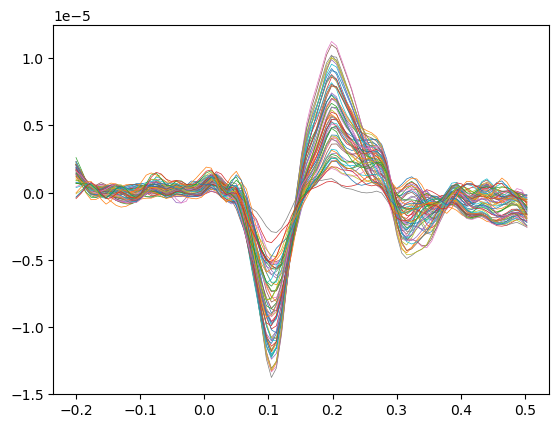

In [357]:
#sanity check 

#only works if sub_ave = False

print('shape of epochs:',epochs_df.iloc[0]['epochs'].shape)

if sub_ave:
    plt.plot(erp_times_crop, np.mean(epochs_df['epochs']).T, linewidth = 0.5);

else: #if not averaged, just 
    plt.plot(erp_times_crop, np.mean(epochs_df.iloc[0]['epochs'], axis = 0).T, linewidth = 0.5);

In [358]:
save_epochs = False
save_mat = True
save_csv = True

start_time_str = str(erp_begin_crop).replace('.', '_').replace('-', 'n')
end_time_str = str(erp_end_crop).replace('.', '_').replace('-', 'n')


if save_epochs:
    if save_mat:

        #this part works if sub_ave is true but not if sub_ave is false
        """musicians_pre = np.array(epochs_df.query("period == 'pre' and musician == 1")['epochs'].tolist())
        musicians_post = np.array(epochs_df.query("period == 'post' and musician == 1")['epochs'].tolist())
        nonmusicians_pre = np.array(epochs_df.query("period == 'pre' and musician == 0")['epochs'].tolist())
        nonmusicians_post = np.array(epochs_df.query("period == 'post' and musician == 0")['epochs'].tolist())
        """

        musicians_pre = epochs_df.query("period == 'pre' and musician == 1")['epochs'].tolist()
        musicians_post = epochs_df.query("period == 'post' and musician == 1")['epochs'].tolist()
        nonmusicians_pre = epochs_df.query("period == 'pre' and musician == 0")['epochs'].tolist()
        nonmusicians_post = epochs_df.query("period == 'post' and musician == 0")['epochs'].tolist()
    
        savemat(f'{task}_epochs_bysubject_{start_time_str}to{end_time_str}_bytrial_30Hz.mat',{
            'mus_pre': musicians_pre,
            'mus_post': musicians_post,
            'nmus_pre': nonmusicians_pre,
            'nmus_post': nonmusicians_post,
            'fs':128,
            'erp_times': erp_times_crop

        })
    if save_csv:
        epochs_df.to_csv(f'{task}_epochs_bysubject_{start_time_str}to{end_time_str}_bytrial_30Hz.csv')

In [359]:
listen = loadmat('listen_epochs_bysubject_n0_2to0_5_bytrial_30Hz.mat')
listen['nmus_post'].shape

FileNotFoundError: [Errno 2] No such file or directory: 'listen_epochs_bysubject_n0_2to0_5_bytrial_30Hz.mat'

In [ ]:
#epochs_df